In [ ]:
#%% env: new-ml

from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm   
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import numpy as np
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#%%
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
# train_target = train_target[['EMB_MIC']]
# # don't touch test data, split out validation data from training data during training
# # test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
# test_target = test_target[['EMB_MIC']]

# all_data = np.concatenate((train_data, test_data), axis=0)
# all_target = pd.concat((train_target, test_target), axis=0)

# train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

In [6]:

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
    
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
      in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

### data

In [7]:
clinical_lung = pd.read_csv('/mnt/storageG1/lwang/Projects/TBpt/Analysis/clinical_lung17102024.csv')
clinical_lung.drop(columns=['condition_id'], inplace=True)

country_mapping = {
    'China': 1,        # High medical capacity, large infrastructure, advanced technology
    'India': 2,        # Large infrastructure, but strained capacity due to population
    'South Africa': 3, # Developed healthcare, but regional disparities
    'Romania': 4,      # Developing EU healthcare standards
    'Ukraine': 5,      # Moderate capacity but strained due to recent conflicts
    'Belarus': 6,      # Moderate capacity, state-funded healthcare
    'Kazakhstan': 7,   # Developing healthcare system
    'Azerbaijan': 8,   # Developing healthcare system
    'Georgia': 9,      # Smaller healthcare capacity, improving
    'Moldova': 10,     # Limited resources, developing healthcare
    'Kyrgyzstan': 11,  # Limited resources, developing healthcare
    'Nigeria': 12,     # Limited healthcare capacity, large population challenges
    'Senegal': 13      # Developing healthcare system with limited resources
}

# Apply the mapping to the 'country' column
clinical_lung['country'] = clinical_lung['country'].replace(country_mapping).fillna(0)

In [8]:
clinical_lung_features = clinical_lung[[ 'overall_percent_of_abnormal_volume',
       'pleural_effusion_percent_of_hemithorax_involved',
       'ispleuraleffusionbilateral', 'other_non_tb_abnormalities',
       'are_mediastinal_lymphnodes_present', 'collapse', 'smallcavities',
       'mediumcavities', 'largecavities',
       'isanylargecavitybelongtoamultisextantcavity',
       'canmultiplecavitiesbeseen', 'infiltrate_lowgroundglassdensity',
       'infiltrate_mediumdensity', 'infiltrate_highdensity', 'smallnodules',
       'mediumnodules', 'largenodules', 'hugenodules',
       'isanycalcifiedorpartiallycalcifiednoduleexist',
       'isanynoncalcifiednoduleexist', 'isanyclusterednoduleexists',
       'aremultiplenoduleexists', 'lowgroundglassdensityactivefreshnodules',
       'mediumdensitystabalizedfibroticnodules',
       'highdensitycalcifiedtypicallysequella', 'timika_score',
       'education', 'gender', 'employment', 'type_of_resistance',
       'number_of_daily_contacts', 'bmi', 'lung_localization', 'totalcavernum',
       'case_definition', 'diagnosis_code', 'comorbidity',
       'social_risk_factors']]#'condition_id','country'

clinical_lung_labels = clinical_lung[['outcome']]

In [ ]:
import xgboost as xgb


scaler = StandardScaler()
X_scaled = scaler.fit_transform(clinical_lung_features)
# Prepare your data
# Assuming train_data, test_data, train_target_y, and test_target_y are already defined
print(f"Data shape: {X_scaled.shape}")
print(f"Label shape: {clinical_lung_labels.shape}")
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, clinical_lung_labels, test_size=0.2, random_state=42)

# Create the XGBoost model
model_bi = xgb.XGBClassifier()
model_bi.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_bi.predict(X_test)

# Evaluate the model_bi
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#testing
cutoff = 4
test_target_bi = y_test.astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = y_pred.astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()
print(confusion_matrix(test_target_bi, test_predictions_bi))

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Data shape: (10150, 38)
Label shape: (10150, 1)
Accuracy: 0.8054187192118226
AUC: 0.6445714008305861
[[ 156  267]
 [ 128 1479]]
Sensitivity: 0.9203484754200373
Specificity: 0.36879432624113473


### PCA

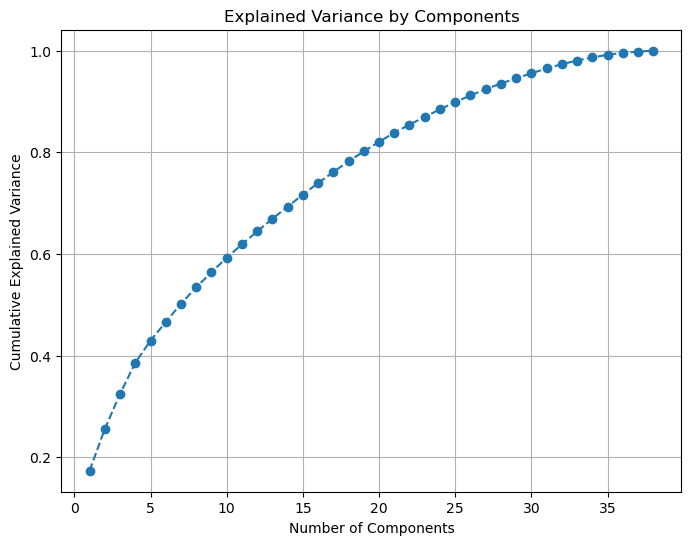

In [5]:
# If necessary, handle missing values
# df = df.dropna()  # Option to drop missing values
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select numeric columns for PCA
numeric_cols = clinical_lung_features.select_dtypes(include=[np.number]).columns
df_numeric = clinical_lung_features[numeric_cols]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Initialize PCA
pca = PCA()

# Fit PCA on the scaled data
pca.fit(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [ ]:
# Choose number of components to explain 90% variance
explained_variance_threshold = 0.90
n_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
print(f'Number of components explaining {explained_variance_threshold*100}% variance: {n_components}')

# Apply PCA with the selected number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Create column names for principal components
pc_columns = [f'PC{i+1}' for i in range(n_components)]

# Create a DataFrame with principal components
df_pca = pd.DataFrame(data=X_pca, columns=pc_columns)

# Optionally, add back any non-numeric columns you excluded earlier
# df_pca = pd.concat([df_pca, df[non_numeric_cols].reset_index(drop=True)], axis=1)
# Get the loading scores (components)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, index=numeric_cols, columns=pc_columns)
print(loadings_df)

plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First two principal components')
plt.grid(True)
plt.show()


In [8]:
from sklearn.neighbors import kneighbors_graph
import numpy as np

# Example data: each row is a sample, each column is a feature

# Generate a k-nearest neighbors graph, specifying the number of neighbors
n_neighbors = 5
# knn_graph = kneighbors_graph(clinical_lung_features, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
knn_graph = kneighbors_graph(df_pca, n_neighbors=n_neighbors, mode='connectivity', include_self=False)

# Convert the sparse matrix to dense format if needed
dense_matrix = knn_graph.toarray()

row_indices, col_indices = np.nonzero(dense_matrix)

# Stack these indices to create an edge index (2 x num_edges)
edge_index = np.stack([row_indices, col_indices], axis=0)

# Convert edge_index to a PyTorch tensor (if you're using PyTorch Geometric)
edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)

# Now edge_index_tensor is in the format that a GCN can use: (2 x num_edges)
print(edge_index_tensor)
# Check the unique values in the generated matrix
# unique_values = np.unique(dense_matrix)
# print("Unique values:", unique_values)
adjacency_matrix = dense_matrix

tensor([[    0,     0,     0,  ..., 10149, 10149, 10149],
        [  391,  1551,  5283,  ...,  2445,  5013,  5112]])


In [36]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Assume clinical_lung_features is your input DataFrame and clinical_lung_labels is your labels Series
# clinical_lung_features: DataFrame of shape (10150, 38)
# clinical_lung_labels: Series of shape (10150,)

# Convert features and labels to numpy arrays
features = clinical_lung_features.values  # shape (10150, 38)
# features = df_pca.values  # shape (10150, 38)
labels = clinical_lung_labels.values      # shape (10150,)

# Parameters
n_neighbors = 5  # Number of neighbors for KNN graph

# Step 1: Perform stratified split into train+val and test sets
train_val_indices, test_indices = train_test_split(
    np.arange(features.shape[0]),
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Step 2: Further split the train+val set into training and validation sets
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of the total data
    random_state=42,
    stratify=labels[train_val_indices]
)

# Function to remove duplicates and create adjacency matrix
def prepare_dataset(indices, features, labels, n_neighbors):
    # Extract subset features and labels
    subset_features = features[indices]
    subset_labels = labels[indices]

    # Combine features and labels into a DataFrame to remove duplicates
    subset_data = pd.DataFrame(subset_features)
    subset_data['label'] = subset_labels

    # Remove duplicates
    subset_data = subset_data.drop_duplicates().reset_index(drop=True)

    # Separate features and labels after removing duplicates
    subset_features = subset_data.iloc[:, :-1].values
    subset_labels = subset_data['label'].values

    # Create adjacency matrix using KNN graph
    knn_graph = kneighbors_graph(subset_features, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
    # Get edge indices
    row_indices, col_indices = knn_graph.nonzero()
    edge_index = np.stack([row_indices, col_indices], axis=0)
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)

    # Convert features and labels to tensors
    features_tensor = torch.tensor(subset_features, dtype=torch.float32)
    labels_tensor = torch.tensor(subset_labels, dtype=torch.long)

    return features_tensor, labels_tensor, edge_index_tensor

# Prepare training dataset
train_features_tensor, train_labels_tensor, train_edge_index_tensor = prepare_dataset(
    train_indices, features, labels, n_neighbors
)

# Prepare validation dataset
val_features_tensor, val_labels_tensor, val_edge_index_tensor = prepare_dataset(
    val_indices, features, labels, n_neighbors
)

# Prepare test dataset
test_features_tensor, test_labels_tensor, test_edge_index_tensor = prepare_dataset(
    test_indices, features, labels, n_neighbors
)

# Create PyTorch Geometric Data objects
train_data = Data(x=train_features_tensor, edge_index=train_edge_index_tensor, y=train_labels_tensor)
val_data = Data(x=val_features_tensor, edge_index=val_edge_index_tensor, y=val_labels_tensor)
test_data = Data(x=test_features_tensor, edge_index=test_edge_index_tensor, y=test_labels_tensor)

# Now you can proceed to create DataLoaders and define your GCN model


In [37]:

# # Step 2: Create the edge_index for both training and testing
# # You could keep the same adjacency matrix for both if the graph structure is the same.
# def adjacency_to_edge_index(adj_matrix):
#     edge_index = np.array(np.nonzero(adj_matrix))  # Get the non-zero indices of the adjacency matrix
#     return torch.tensor(edge_index, dtype=torch.long)

# edge_index = adjacency_to_edge_index(adjacency_matrix)
# edge_index_train = adjacency_to_edge_index(train_adj_matrix)
# edge_index_val = adjacency_to_edge_index(val_adj_matrix )
# edge_index_test = adjacency_to_edge_index(test_adj_matrix)

# # Step 3: Create PyTorch Geometric Data objects if you're using graph data
# train_data = Data(x=train_features, edge_index=torch.tensor(edge_index_train), y=train_labels)
# val_data = Data(x=val_features, edge_index=torch.tensor(edge_index_val), y=val_labels)
# test_data = Data(x=test_features, edge_index=torch.tensor(edge_index_test), y=test_labels)


### weighted criterion

In [38]:
flattened_tensor = train_labels_tensor.flatten()
# Convert the flattened tensor to a DataFrame
_ = pd.DataFrame(flattened_tensor.numpy(), columns=['a'])

y_true = _
# y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for column in y_true.columns:
    column_values = y_true[column].dropna().values
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1/frequency
    # weights_inverse = 1 - frequency
    
    # Normalize weights to ensure they sum up to 1
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    column_weight_maps[column] = weight_map


def get_weighted_masked_cross_entropy_loss(column_weight_maps):
    """
    Creates a loss function that computes a weighted cross entropy loss, taking into account class imbalances.
    :param column_weight_maps: Dictionary mapping column names to their corresponding class weight maps.
    """
    def weighted_masked_cross_entropy_loss(y_pred, y_true):
        # weighted_losses = torch.Tensor().to(device)
        weighted_losses = []
        col_weight_map = column_weight_maps
        # print(col_weight_map)
        mean_weight = np.mean(list(col_weight_map.values())) # just in case if a number is not recognised and the loss doesn't go crazy

        # print(y_pred.size())
        # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        weights_col = [col_weight_map.get(y.item(), mean_weight) for y in y_true]
        # print(weights_col)
        # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        loss_fn = F.cross_entropy
        col_loss = loss_fn(y_pred, y_true, reduction = 'none').to(device)
        
        # loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        # col_loss = loss_fn(y_pred, y_true)
        # print(y_true.dtype)
        # print(col_loss)
        weights_col = torch.Tensor(weights_col).to(device)
        # print(weights_col)
        # print(col_loss)
        weighted_col_loss = weights_col * col_loss
        # print(weighted_col_loss)
        weighted_losses.append(weighted_col_loss.mean())

        total_weighted_loss = torch.stack(weighted_losses).mean()
        
        # for i, column in enumerate(column_weight_maps.keys()):
        #     col_weight_map = column_weight_maps[column]
        #     print(y_pred.size())
        #     # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        #     weights_col = torch.tensor([col_weight_map[y.item()] for y in y_true[:, i]], dtype=torch.float32, device=y_true.device)
        #     print(weights_col)
        #     # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        #     loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        #     col_loss = loss_fn(y_pred[:, i,], y_true[:, i])
            
        #     weighted_col_loss = weights_col * col_loss
        #     weighted_losses.append(weighted_col_loss.mean())
        
        # total_weighted_loss = torch.stack(weighted_losses).mean()
        return total_weighted_loss

    return weighted_masked_cross_entropy_loss

# Also assuming `columns` is a list of your target column names corresponding to y_true and y_pred
weighted_cross_entropy_loss_fn = get_weighted_masked_cross_entropy_loss(column_weight_maps['a'])
# loss = weighted_cross_entropy_loss_fn(y_true_tensor, y_pred_logits, columns)

### model

In [31]:
# GCN Model (same as before)
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # First GCN layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        # return F.log_softmax(x, dim=1)
        return x

# Instantiate the model, optimizer, and loss function
input_dim = train_features_tensor.shape[1]  # 38 features in the input
hidden_dim = 64  # Arbitrary hidden layer size
output_dim = 2  # Number of output classes, adjust this based on your problem

model = GCN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()
criterion = weighted_cross_entropy_loss_fn

## model1

In [39]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, LayerNorm
from torch_geometric.nn import GCNConv, BatchNorm
from torch.nn.utils import weight_norm

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.5):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        
        self.dropout_rate = dropout_rate

        # Input dropout
        self.input_dropout = torch.nn.Dropout(p=self.dropout_rate)

        # First GCN layer
        self.convs.append(GCNConv(input_dim, hidden_dims[0]))
        self.bns.append(BatchNorm(hidden_dims[0]))
        
        # Additional GCN layers
        for i in range(len(hidden_dims) - 1):
            self.convs.append(GCNConv(hidden_dims[i], hidden_dims[i+1]))
            self.bns.append(BatchNorm(hidden_dims[i+1]))
        
        # Fully connected layers with weight normalization
        self.fc1 = Linear(hidden_dims[-1], hidden_dims[-1] // 2)
        self.fc1 = weight_norm(self.fc1)
        self.fc2 = Linear(hidden_dims[-1] // 2, output_dim)
        self.fc2 = weight_norm(self.fc2)
        
        # Layer normalization for fully connected layers
        self.layer_norm1 = LayerNorm(hidden_dims[-1] // 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply input dropout
        x = self.input_dropout(x)

        # Apply GCN layers with ReLU activation and BatchNorm
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.layer_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.fc2(x)
        
        return x


# new training without dataloader

  8%|▊         | 50/600 [00:45<10:13,  1.12s/it]

Epoch 50, Train Loss: 0.2097739577293396, Train Acc: 0.7739084320311119, Val Loss: 0.22076547145843506, Val Acc: 0.7808433107756377


 17%|█▋        | 100/600 [01:21<07:28,  1.12it/s]

Epoch 100, Train Loss: 0.20661893486976624, Train Acc: 0.7081491956867597, Val Loss: 0.20917180180549622, Val Acc: 0.7126496616345653


 25%|██▌       | 150/600 [01:46<03:07,  2.39it/s]

Epoch 150, Train Loss: 0.20062081515789032, Train Acc: 0.7281244475870603, Val Loss: 0.2082592397928238, Val Acc: 0.6928682977615825


 33%|███▎      | 200/600 [01:59<02:29,  2.67it/s]

Epoch 200, Train Loss: 0.19742582738399506, Train Acc: 0.5785752165458724, Val Loss: 0.21283817291259766, Val Acc: 0.5434669442998439


 42%|████▏     | 250/600 [02:14<01:51,  3.13it/s]

Epoch 250, Train Loss: 0.1966569572687149, Train Acc: 0.7687820399505038, Val Loss: 0.22268083691596985, Val Acc: 0.7438833940655908


 50%|█████     | 301/600 [02:26<01:23,  3.56it/s]

Epoch 300, Train Loss: 0.1950300633907318, Train Acc: 0.6116316068587591, Val Loss: 0.21126899123191833, Val Acc: 0.5762623633524206


 58%|█████▊    | 350/600 [02:39<01:18,  3.18it/s]

Epoch 350, Train Loss: 0.19238455593585968, Train Acc: 0.5805197100936892, Val Loss: 0.22702085971832275, Val Acc: 0.5101509630400833


 67%|██████▋   | 400/600 [02:53<01:29,  2.24it/s]

Epoch 400, Train Loss: 0.19548803567886353, Train Acc: 0.7350185610747746, Val Loss: 0.21563297510147095, Val Acc: 0.7058823529411765


 75%|███████▌  | 450/600 [03:06<00:45,  3.29it/s]

Epoch 450, Train Loss: 0.19249950349330902, Train Acc: 0.6825172352837193, Val Loss: 0.21183976531028748, Val Acc: 0.6637168141592921


 83%|████████▎ | 500/600 [03:19<00:30,  3.29it/s]

Epoch 500, Train Loss: 0.19809278845787048, Train Acc: 0.6420364150609864, Val Loss: 0.2124508172273636, Val Acc: 0.6132222800624675


 92%|█████████▏| 550/600 [03:32<00:16,  3.10it/s]

Epoch 550, Train Loss: 0.19799956679344177, Train Acc: 0.6987802722290967, Val Loss: 0.21276438236236572, Val Acc: 0.6710046850598647


100%|██████████| 600/600 [03:46<00:00,  2.65it/s]

Epoch 600, Train Loss: 0.19354140758514404, Train Acc: 0.631430086618349, Val Loss: 0.21521660685539246, Val Acc: 0.5767829255596044


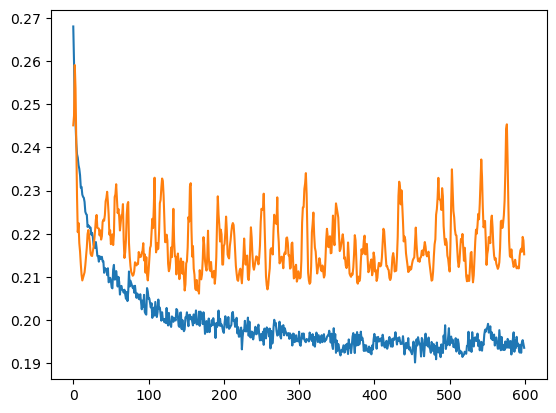

In [43]:

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
for _ in [1e-5]:
    # [Your data preparation code]
    # Assume you have prepared:
    # - train_features_tensor, train_labels_tensor, train_edge_index_tensor
    # - val_features_tensor, val_labels_tensor, val_edge_index_tensor
    # - test_features_tensor, test_labels_tensor, test_edge_index_tensor

    # Step 1: Create Data Objects
    train_data = Data(x=train_features_tensor, edge_index=train_edge_index_tensor, y=train_labels_tensor)
    val_data = Data(x=val_features_tensor, edge_index=val_edge_index_tensor, y=val_labels_tensor)
    test_data = Data(x=test_features_tensor, edge_index=test_edge_index_tensor, y=test_labels_tensor)

    # # Step 2: Define the Model
    # class GCN(torch.nn.Module):
    #     def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.5):
    #         super(GCN, self).__init__()
    #         self.convs = torch.nn.ModuleList()
    #         self.batch_norms = torch.nn.ModuleList()

    #         # Input layer
    #         self.convs.append(GCNConv(input_dim, hidden_dims[0]))
    #         self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dims[0]))

    #         # Hidden layers
    #         for i in range(len(hidden_dims) - 1):
    #             self.convs.append(GCNConv(hidden_dims[i], hidden_dims[i + 1]))
    #             self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dims[i + 1]))

    #         # Output layer
    #         self.fc = torch.nn.Linear(hidden_dims[-1], output_dim)
    #         self.dropout_rate = dropout_rate

    #     def forward(self, data):
    #         x, edge_index = data.x, data.edge_index

    #         for conv, bn in zip(self.convs, self.batch_norms):
    #             x = conv(x, edge_index)
    #             x = bn(x)
    #             x = F.relu(x)
    #             x = F.dropout(x, p=self.dropout_rate, training=self.training)

    #         x = self.fc(x)
    #         return x

    input_dim = train_data.num_node_features
    hidden_dims = [128, 64, 64, 64, 32, 32]
    output_dim = len(torch.unique(train_data.y))
    dropout_rate = 0.1
    learning_rate = 0.01
    weight_decay = 1e-4
    num_epochs = 600

    # Step 3: Prepare Training
    model = GCN(input_dim, hidden_dims, output_dim, dropout_rate)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    train_data = train_data.to(device)
    val_data = val_data.to(device)
    test_data = test_data.to(device)

    # Define optimizer with weight decay
    weight_decay = 5e-4  # Adjust as needed
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # criterion = torch.nn.CrossEntropyLoss()
    criterion = weighted_cross_entropy_loss_fn


    def l1_regularization(model, l1_lambda):
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        return l1_lambda * l1_norm

    # In your training function
    def train():
        model.train()
        optimizer.zero_grad()
        out = model(train_data)
        loss = criterion(out, train_data.y)
        # Add L1 regularization
        l1_lambda = 1e-5  # Adjust as needed
        l1_reg = l1_regularization(model, l1_lambda)
        loss = loss + l1_reg
        loss.backward()
        optimizer.step()
        return loss.item()

    def evaluate(data):
        model.eval()
        with torch.no_grad():
            out = model(data)
            preds = out.argmax(dim=1)
            correct = (preds == data.y).sum().item()
            acc = correct / data.num_nodes
            loss = criterion(out, data.y)

        return acc, loss.item()

    # Step 4: Train the Model
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(1, num_epochs + 1)):
        train_loss = train()
        val_acc, val_loss = evaluate(val_data)
        if epoch % 50 == 0:
            train_acc = evaluate(train_data)
            # val_acc, val_loss = evaluate(val_data)
            # print(f'Epoch {epoch:03d}, TrainLoss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
            print(f'Epoch {epoch}, Train Loss: {train_loss}, Train Acc: {train_acc[0]}, Val Loss: {val_loss}, Val Acc: {val_acc}')
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    # Test the model    
    test_acc = evaluate(test_data)
    # print(f'Test Accuracy: {test_acc:.4f}')

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')


/mnt/storageG1/lwang/miniconda3/envs/new-ml/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
  8%|▊         | 51/600 [00:07<01:33,  5.90it/s]

Epoch 50, Train Loss: 0.2423894703388214, Train Acc: 0.5973130634611985, Val Loss: 0.2129540741443634, Val Acc: 0.5762623633524206


 17%|█▋        | 101/600 [00:15<01:25,  5.86it/s]

Epoch 100, Train Loss: 0.2355719804763794, Train Acc: 0.6280714159448471, Val Loss: 0.2083512544631958, Val Acc: 0.6272774596564289


 25%|██▌       | 151/600 [00:23<01:15,  5.93it/s]

Epoch 150, Train Loss: 0.2324100285768509, Train Acc: 0.6270107831005833, Val Loss: 0.20769527554512024, Val Acc: 0.6205101509630401


 34%|███▎      | 201/600 [00:30<01:07,  5.92it/s]

Epoch 200, Train Loss: 0.225589781999588, Train Acc: 0.6204702138942902, Val Loss: 0.20807018876075745, Val Acc: 0.6074960957834461


 42%|████▏     | 251/600 [00:38<01:01,  5.63it/s]

Epoch 250, Train Loss: 0.22276677191257477, Train Acc: 0.6459254021566201, Val Loss: 0.20721375942230225, Val Acc: 0.6231129619989588


 50%|█████     | 301/600 [00:45<00:50,  5.87it/s]

Epoch 300, Train Loss: 0.21858152747154236, Train Acc: 0.6411525543574332, Val Loss: 0.20692653954029083, Val Acc: 0.6345653305570016


 58%|█████▊    | 351/600 [00:53<00:42,  5.90it/s]

Epoch 350, Train Loss: 0.21892818808555603, Train Acc: 0.6266572388191621, Val Loss: 0.20937585830688477, Val Acc: 0.601249349297241


 67%|██████▋   | 401/600 [01:01<00:41,  4.81it/s]

Epoch 400, Train Loss: 0.21478085219860077, Train Acc: 0.6765069824995581, Val Loss: 0.20647792518138885, Val Acc: 0.6579906298802707


 75%|███████▌  | 451/600 [01:08<00:25,  5.92it/s]

Epoch 450, Train Loss: 0.21141311526298523, Train Acc: 0.669966413293265, Val Loss: 0.20608942210674286, Val Acc: 0.6428943258719417


 84%|████████▎ | 501/600 [01:16<00:16,  5.92it/s]

Epoch 500, Train Loss: 0.21017614006996155, Train Acc: 0.6775676153438218, Val Loss: 0.20633690059185028, Val Acc: 0.6652785007808433


 92%|█████████▏| 551/600 [01:23<00:08,  5.76it/s]

Epoch 550, Train Loss: 0.2095056176185608, Train Acc: 0.6768605267809793, Val Loss: 0.2073405385017395, Val Acc: 0.6397709526288391


100%|██████████| 600/600 [01:31<00:00,  6.56it/s]

Epoch 600, Train Loss: 0.20949016511440277, Train Acc: 0.6796888810323493, Val Loss: 0.2075020968914032, Val Acc: 0.6668401874023946


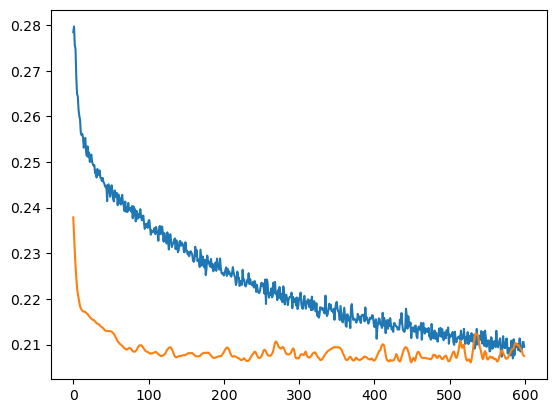

In [40]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph

# [Your data preparation code]
# Assume you have prepared:
# - train_features_tensor, train_labels_tensor, train_edge_index_tensor
# - val_features_tensor, val_labels_tensor, val_edge_index_tensor
# - test_features_tensor, test_labels_tensor, test_edge_index_tensor

# Step 1: Create Data Objects
train_data = Data(x=train_features_tensor, edge_index=train_edge_index_tensor, y=train_labels_tensor)
val_data = Data(x=val_features_tensor, edge_index=val_edge_index_tensor, y=val_labels_tensor)
test_data = Data(x=test_features_tensor, edge_index=test_edge_index_tensor, y=test_labels_tensor)

# # Step 2: Define the Model
# class GCN(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.5):
#         super(GCN, self).__init__()
#         self.convs = torch.nn.ModuleList()
#         self.batch_norms = torch.nn.ModuleList()

#         # Input layer
#         self.convs.append(GCNConv(input_dim, hidden_dims[0]))
#         self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dims[0]))

#         # Hidden layers
#         for i in range(len(hidden_dims) - 1):
#             self.convs.append(GCNConv(hidden_dims[i], hidden_dims[i + 1]))
#             self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dims[i + 1]))

#         # Output layer
#         self.fc = torch.nn.Linear(hidden_dims[-1], output_dim)
#         self.dropout_rate = dropout_rate

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index

#         for conv, bn in zip(self.convs, self.batch_norms):
#             x = conv(x, edge_index)
#             x = bn(x)
#             x = F.relu(x)
#             x = F.dropout(x, p=self.dropout_rate, training=self.training)

#         x = self.fc(x)
#         return x

input_dim = train_data.num_node_features
hidden_dims = [128, 64, 64, 64, 32, 32]
output_dim = len(torch.unique(train_data.y))
dropout_rate = 0.3
learning_rate = 0.001
weight_decay = 1e-4
num_epochs = 600

# Step 3: Prepare Training
model = GCN(input_dim, hidden_dims, output_dim, dropout_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

# Define optimizer with weight decay
weight_decay = 5e-4  # Adjust as needed
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# criterion = torch.nn.CrossEntropyLoss()
criterion = weighted_cross_entropy_loss_fn


def l1_regularization(model, l1_lambda):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return l1_lambda * l1_norm

# In your training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = criterion(out, train_data.y)
    # Add L1 regularization
    l1_lambda = 1e-5  # Adjust as needed
    l1_reg = l1_regularization(model, l1_lambda)
    loss = loss + l1_reg
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        preds = out.argmax(dim=1)
        correct = (preds == data.y).sum().item()
        acc = correct / data.num_nodes
        loss = criterion(out, data.y)

    return acc, loss.item()

# Step 4: Train the Model
train_losses = []
val_losses = []
for epoch in tqdm(range(1, num_epochs + 1)):
    train_loss = train()
    val_acc, val_loss = evaluate(val_data)
    if epoch % 50 == 0:
        train_acc = evaluate(train_data)
        # val_acc, val_loss = evaluate(val_data)
        # print(f'Epoch {epoch:03d}, TrainLoss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print(f'Epoch {epoch}, Train Loss: {train_loss}, Train Acc: {train_acc[0]}, Val Loss: {val_loss}, Val Acc: {val_acc}')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
# Test the model    
test_acc = evaluate(test_data)
# print(f'Test Accuracy: {test_acc:.4f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')


In [ ]:
for _ in [1e-3]:
    print('=== testing variables', _)
    
    # lr = 1e-3 #0.8044
    # input_dim = train_features_tensor.shape[1]  # 38 features in the input
    # hidden_dim = [128, 64, 32]  # Arbitrary hidden layer size
    # output_dim = 2  # Number of output classes, adjust this based on your problem
    # Hyperparameters
    input_dim = train_data.num_node_features
    hidden_dims = [64, 32]
    output_dim = len(torch.unique(train_data.y))
    dropout_rate = 0.5
    learning_rate = 0.001
    weight_decay = 5e-4
    num_epochs = 100
    

    model = GCN(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # criterion = torch.nn.CrossEntropyLoss()
    criterion = weighted_cross_entropy_loss_fn
    num_epochs = 300
    
    # Step 4: Train the Model
    
    for epoch in range(1, num_epochs + 1):
        loss = train()
        if epoch % 10 == 0:
            train_acc = evaluate(train_data)
            val_acc = evaluate(val_data)
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    # Test the model
    test_acc = evaluate(test_data)
    print(f'Test Accuracy: {test_acc:.4f}')

# old training with dataloader

In [15]:
import torch
import torch.nn.functional as F

# Define the training function
def train(model, optimizer, criterion, train_loader):
    model.train()  # Set the model to training mode
    total_loss = 0  # Track total loss for the epoch
    
    for batch in train_loader:
        optimizer.zero_grad()  # Reset gradients
        out = model(batch)  # Forward pass
        batch_y = batch.y.squeeze()
        loss = criterion(out, batch_y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        total_loss += loss.item()  # Accumulate the batch loss
    
    avg_loss = total_loss / len(train_loader)  # Average loss for the epoch
    # print(f'Training Loss: {avg_loss:.4f}')
    
    return avg_loss

# Define the validation function
def validate(model, criterion, val_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in val_loader:
            out = model(batch)  # Forward pass
            batch_y = batch.y.squeeze()
            loss = criterion(out, batch_y)  # Compute loss
            total_loss += loss.item()  # Accumulate the batch loss
            
            pred = out.argmax(dim=1)  # Get predictions
            correct += (pred == batch.y).sum().item()  # Count correct predictions
            
            all_preds.extend(pred.cpu().numpy())  # Store predictions
            all_labels.extend(batch.y.cpu().numpy())  # Store true labels

    accuracy = correct / len(val_loader.dataset)  # Compute accuracy
    avg_loss = total_loss / len(val_loader)  # Average loss for the epoch
    # print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
    
    return avg_loss, accuracy


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in test_loader:
            out = model(batch)  # Forward pass
            pred = out.argmax(dim=1)  # Get the predicted class (highest score)
            all_preds.extend(pred.cpu().numpy())  # Store predictions
            all_labels.extend(batch.y.cpu().numpy())  # Store true labels

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    sensitivity = recall_score(all_labels, all_preds)  # Same as recall
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    
    # Output results
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Sensitivity (Recall): {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    
    return accuracy, sensitivity, specificity, conf_matrix

# Combine training and validation in the epoch loop
def train_and_validate(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs=100):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in tqdm(range(num_epochs)):
        # print(f'Epoch {epoch + 1}/{num_epochs}')
        
        # Training step
        train_loss = train(model, optimizer, criterion, train_loader)
        
        # Validation step
        val_loss, val_accuracy = validate(model, criterion, val_loader)

        # Store losses and accuracy
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        if epoch %  100 == 0:
            print(f'Epoch {epoch + 1} completed. Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n')
            # print(f'Epoch {epoch + 1} completed. Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%\n')

    # Plotting the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    test(model, test_loader)
    # Optionally, you can also plot validation accuracy
    # plt.figure(figsize=(10, 5))
    # plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.title('Validation Accuracy')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

## Training

In [27]:

# Step 4: Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

for _ in [1e-3]:
    print('=== testing variables', _)
    
    lr = 1e-3 #0.8044
    input_dim = train_features_tensor.shape[1]  # 38 features in the input
    hidden_dim = [128, 64, 32]  # Arbitrary hidden layer size
    output_dim = 2  # Number of output classes, adjust this based on your problem

    model = GCN(input_dim, hidden_dim, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # criterion = torch.nn.CrossEntropyLoss()
    criterion = weighted_cross_entropy_loss_fn
    num_epochs = 300

    train_and_validate(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)

=== testing variables 0.001


  0%|          | 0/300 [00:00<?, ?it/s]


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'torch_geometric.data.data.Data'>

## cache

In [ ]:

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assume clinical_lung_features is your input DataFrame and adjacency_matrix is your edge matrix
features = clinical_lung_features.values  # shape (10150, 38)
adjacency_matrix = adjacency_matrix  # shape (10150, 10150)

# Assume y is your labels column in the dataframe
y = clinical_lung_labels  # Replace this with your actual labels (shape: 10150,)

# Step 1: Perform stratified split into train+val and test sets
train_val_indices, test_indices = train_test_split(
    np.arange(features.shape[0]),
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensure that the split is stratified based on the labels
)

# Step 2: Further split the train+val set into separate training and validation sets
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.25,  # 25% of train+val becomes the validation set, so 0.25 * 0.8 = 0.2 of the total data
    random_state=42,
    stratify=y.iloc[train_val_indices]  # Stratify based on the labels in the train+val set
)

# Separate features and labels based on the indices
train_features = torch.tensor(features[train_indices], dtype=torch.float32)
train_labels = torch.tensor(y.iloc[train_indices].values, dtype=torch.long)
unique_rows, indices, counts = np.unique(train_features, axis=0, return_index=True, return_counts=True)
train_features = train_features[indices]
train_labels = train_labels[indices]



val_features = torch.tensor(features[val_indices], dtype=torch.float32)
val_labels = torch.tensor(y.iloc[val_indices].values, dtype=torch.long)
unique_rows, indices, counts = np.unique(train_features, axis=0, return_index=True, return_counts=True)
train_features = train_features[indices]
train_labels = train_labels[indices]



test_features = torch.tensor(features[test_indices], dtype=torch.float32)
test_labels = torch.tensor(y.iloc[test_indices].values, dtype=torch.long)
unique_rows, indices, counts = np.unique(train_features, axis=0, return_index=True, return_counts=True)
train_features = train_features[indices]
train_labels = train_labels[indices]


# Train labels, validation labels, and test labels  

# # Train adjacency matrix (rows and columns of the train_indices)
# train_adj_matrix = adjacency_matrix[np.ix_(train_indices, train_indices)]

# # Validation adjacency matrix (rows and columns of the val_indices)
# val_adj_matrix = adjacency_matrix[np.ix_(val_indices, val_indices)]

# # Test adjacency matrix (rows and columns of the test_indices)
# test_adj_matrix = adjacency_matrix[np.ix_(test_indices, test_indices)]  



In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assume clinical_lung_features is your input DataFrame and adjacency_matrix is your edge matrix
features = clinical_lung_features.values  # shape (10150, 38)
adjacency_matrix = adjacency_matrix  # shape (10150, 10150)

# Assume y is your labels column in the dataframe
y = clinical_lung_labels  # Replace this with your actual labels (shape: 10150,)

# Step 1: Perform stratified split into train+val and test sets
train_val_indices, test_indices = train_test_split(
    np.arange(features.shape[0]),
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensure that the split is stratified based on the labels
)

# Step 2: Further split the train+val set into separate training and validation sets
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.25,  # 25% of train+val becomes the validation set, so 0.25 * 0.8 = 0.2 of the total data
    random_state=42,
    stratify=y.iloc[train_val_indices]  # Stratify based on the labels in the train+val set
)

# Separate features and labels based on the indices
train_features = torch.tensor(features[train_indices], dtype=torch.float32)
val_features = torch.tensor(features[val_indices], dtype=torch.float32)
test_features = torch.tensor(features[test_indices], dtype=torch.float32)

train_labels = torch.tensor(y.iloc[train_indices].values, dtype=torch.float16)
val_labels = torch.tensor(y.iloc[val_indices].values, dtype=torch.float16)
test_labels = torch.tensor(y.iloc[test_indices].values, dtype=torch.float16)

# Train adjacency matrix (rows and columns of the train_indices
# Train, val, and test indices (these would be your node splits)
train_indices = train_indices
val_indices = val_indices
test_indices = test_indices

# Step 1: Create sets of indices for quick lookup
train_set = set(train_indices)
val_set = set(val_indices)
test_set = set(test_indices)

# Step 2: Function to filter edges for specific index set
def filter_edges_by_node_split(edge_index, node_set):
    mask = [(src in node_set) and (dst in node_set) for src, dst in zip(edge_index[0], edge_index[1])]
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

# Step 3: Filter edges for train, validation, and test
train_edge_index = filter_edges_by_node_split(edge_index_tensor, train_indices)
val_edge_index = filter_edges_by_node_split(edge_index_tensor, val_indices)
test_edge_index = filter_edges_by_node_split(edge_index_tensor, test_indices)

# Now you can use these for respective splits
print("Train Edge Index:", train_edge_index)
print("Validation Edge Index:", val_edge_index)
print("Test Edge Index:", test_edge_index)

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader, loader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np

# Assume clinical_lung_features is your input DataFrame and adjacency_matrix is your edge matrix

# Step 1: Convert DataFrame (features) and adjacency matrix into PyTorch tensors
features = torch.tensor(clinical_lung_features.values, dtype=torch.float32)  # shape (10150, 38)
adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)  # shape (10150, 10150)

# Create edge_index from adjacency matrix
def adjacency_to_edge_index(adj_matrix):
    edge_index = []
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if adj_matrix[i, j] != 0:  # If there's an edge
                edge_index.append([i, j])
    return torch.tensor(edge_index).t().contiguous()  # Transpose to match PyG's format

edge_index = adjacency_to_edge_index(adjacency_matrix)

In [8]:


# Step 2: Create a PyTorch Geometric Data object
data = Data(x=features, edge_index=edge_index)


In [13]:

# Step 3: Create a DataLoader for batching
batch_size = 64  # You can adjust this as needed
loader = DataLoader([data], batch_size=batch_size, shuffle=True)


In [14]:
# Step 4: Define the GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # First GCN layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
# Step 5: Instantiate the model, loss function, and optimizer
input_dim = features.shape[1]  # 38 features in the input
hidden_dim = 64  # Arbitrary hidden layer size, adjust as needed
output_dim = 2  # Number of output classes, adjust based on your problem

model = GCN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Step 6: Training Loop
def train():
    model.train()
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch)
        # Assume you have labels (use the appropriate labels here)
        loss = criterion(out, batch.y)  # You need to provide actual labels for batch.y
        loss.backward()
        optimizer.step()
        print(f"Training loss: {loss.item()}")

# To run the training function
train()
